# Question 1

In this question we will:

- Design and implement a feature that can be used to creates a feature map sensitive to "greenness".
- Utilize thresholding techniques of this "greenness" feature to obtain a segmentation of green leaves in images with a cluttered background.
- Implement evaluation metrics to measure the quality of a segmentation produced by the thresholding
- Use the metrics to evaluate the segmentation algoirthm's perormance on a dataset of images of green leaves on a cluttered background.

# Step 1: Write your Segmentation Algoirthm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation.  Your algorithm must be based on thresholding.  Determine a metric that can be used to meaure the "greenness" of the colour of a given pixel.  Your algoirthm should create a "feature map" by computing this feature for each pixel, thus creating an "image" where each pixel's "intensity" is the value of the "greenness" feature.   Then use a thresholding method of your choice to segment the image's green regions.    You should also consider whether doing some region processing after segmentation can improve the results.  This function should return the segmenetion of the image as a binary image with a single connected component since you can take advantage of the fact that each image is known to contain only a single leaf.

_Hint: You'll need to be a bit creative when devising your solution -- no single technique from class is likely to give you a particularly good solution, and you may need to think of some tricks that were not explicitly covered in class.  However, you can get a good result with a fairly simple algorithm.  You'll also need to decide how to handle the fact that the input images are colour, although this shouldn't pose too much of a problem, in fact, it is an advantage!_

In [29]:
import skimage.util as util
import skimage.io as io
import numpy as np
import os as os
import skimage.morphology as morph
import skimage.measure as measure
import skimage.transform as trans
from skimage.draw import line
import skimage.filters as filters
from scipy import ndimage as ndi

# You can import other modules as needed.

def segleaf(I):
    '''
    Segment a leaf image.
    :param I: Color leaf image to segment.
    :return: Logical image where True pixels represent foreground (i.e. leaf pixels).
    '''

    I = util.img_as_float(I)
    R = I[..., 0]
    G = I[..., 1]
    B = I[..., 2]
    greenness = 2 * G - R - B

    thresh = filters.threshold_otsu(greenness)
    binary = greenness > thresh

    edges = morph.binary_erosion(binary) ^ binary
    hough_lines = trans.probabilistic_hough_line(edges, threshold=50, line_length=30, line_gap=10)

    refined = np.copy(binary)
    for (x1, y1), (x2, y2) in hough_lines:
        rr, cc = line(int(y1), int(x1), int(y2), int(x2))
        rr = np.clip(rr, 0, refined.shape[0]-1)
        cc = np.clip(cc, 0, refined.shape[1]-1)
        refined[rr, cc] = True

    refined = morph.remove_small_objects(refined, min_size=500)
    refined = morph.binary_closing(refined, morph.disk(5))
    refined = ndi.binary_fill_holes(refined)

    labeled = measure.label(refined)
    regions = measure.regionprops(labeled)
    if len(regions) > 0:
        largest_region = max(regions, key=lambda r: r.area)
        mask = labeled == largest_region.label
    else:
        mask = refined

    
    return mask.astype(bool)   # replace this with your return statement.  This is just a placeholder to prevent a syntax error.

# Step 2: Implement Segmentation Performace Measures

Write functions to compute the Mean Squared Distance (MSD), Hausdorff Distance (HD) and Dice Similarity Coefficient (DSC) measures of segmentation quality.  

For MSD and HD, I suggest you reprsent boundaries by N-row, 2-column arrays where each row is the coordinate of one pixel on the region's boundary of the form [r,c], row first, then column.

In [34]:
from scipy.spatial import distance

def MSD(g, b):
    d = distance.cdist(g, b)
    min1 = np.min(d, axis=1)
    min0 = np.min(d, axis=0)
    
    msd = (np.mean(min1**2) + np.mean(min0**2)) / 2
    return msd

def HD(g, b):
    d = distance.cdist(g, b)
    min1 = np.min(d, axis=1)
    min0 = np.min(d, axis=0)
    
    hd = max(np.max(min1), np.max(min0))
    return hd

def DSC(seg, gt):
    seg = seg.astype(bool)
    gt = gt.astype(bool)
    
    intersection = np.logical_and(seg, gt).sum()
    total = seg.sum() + gt.sum()
    
    if total == 0:
        return 1.0 if intersection == 0 else 0.0
    
    dsc = 2.0 * intersection / total
    return dsc

def boundary_coords(mask):

    boundary = morph.binary_dilation(mask) ^ morph.binary_erosion(mask)
    coords = np.column_stack(np.nonzero(boundary))  # (row, col)
    return coords

# Step 3: Write a Validation driver program.

Write code that segments each image (using the function in Step 1), and computes the MSD, HD, and DSC for each segmentation (using the functions in Step 2).  Print the MSD, HD, and DSC of each segmentation to the console as you perform it.  At the end, print the average and standard deviation of the DSC, the MSD, and the HD over all of the images.  Also print the percentage of regions that were "recognized" (see below).  Sample output is in the assignment description document.

The general approach should be, for each input image:

* load the image and it's ground truth (use the provided leaf image dataset, described in section 2.2. of the assignment PDF) -- a .csv file is provided with the names of all images so that you can process the files in the same manner as Assignment 1, question 1)
* segment the input image using your function from Step 1
* extract the region boundary points from the segmented image and ground truth image; store them in Nx2 arrays as described above (see lecture notes Topic 6, slide 68 for an example on how to do this).
* Compute the MSD and the HD from the two sets of boundary points (using the appropriate functions in Step 2).
* Compute the DSC from the segmented image and the ground truth image (using the appropriate function from Step 2).
* Determine whether the leaf was "recognized" (a leaf is recognized if it's DSC is greater than 0.6).
* Print the MSD, HD, and DSC to the console (see sample output).

When finished processing each image, don't forget to print the average and standard deviation of the DSC for all images, and the percentage of images where the leaf was "recognized".

_Feel free to define additional helper functions for your program if you think it will help._

In [35]:
#### Validate ####
import csv

# Paths for folders -- original and ground truth images
images_path = os.path.join('/u1/cmpt487-819/data/asn3/', 'images')
gt_path = os.path.join('/u1/cmpt487-819/data/asn3/', 'groundtruth')


all_dsc = []
all_msd = []
all_hd = []
recognized_count = 0
total = 0

# Iterate over all files in the original images folder
for root, dirs, files in os.walk(images_path):
    for filename in files:
        # ignore files that are not PNG files.
        if filename[-4:] != '.png':
            continue

        
        # concatenate variable root with filename to get the path to an input file.
        img_path = os.path.join(images_path, filename)
        gt_img_path = os.path.join(gt_path, filename)

        I = io.imread(img_path)
        GT = io.imread(gt_img_path) > 0 

        seg = segleaf(I)

        b_seg = boundary_coords(seg)
        b_gt = boundary_coords(GT)

        msd = MSD(b_seg, b_gt)
        hd = HD(b_seg, b_gt)
        dsc = DSC(seg, GT)

        recognized = dsc > 0.6
        if recognized:
            recognized_count += 1

        all_dsc.append(dsc)
        all_msd.append(msd)
        all_hd.append(hd)
        total += 1

        print(f"Image: {filename}")
        print(f"  MSD = {msd:.4f}")
        print(f"  HD  = {hd:.4f}")
        print(f"  DSC = {dsc:.4f}  {'(recognized)' if recognized else ''}")
        print("--------------------------------------------------")


if total > 0:
    mean_dsc = np.mean(all_dsc)
    std_dsc = np.std(all_dsc)
    mean_msd = np.mean(all_msd)
    std_msd = np.std(all_msd)
    mean_hd = np.mean(all_hd)
    std_hd = np.std(all_hd)
    recognition_rate = 100.0 * recognized_count / total

    print("\n====== Validation Summary ======")
    print(f"Processed {total} images")
    print(f"Average DSC: {mean_dsc:.4f} ± {std_dsc:.4f}")
    print(f"Average MSD: {mean_msd:.4f} ± {std_msd:.4f}")
    print(f"Average HD : {mean_hd:.4f} ± {std_hd:.4f}")
    print(f"Recognized leaves: {recognized_count}/{total} ({recognition_rate:.1f}%)")
    print("================================")
else:
    print("No images processed.")

Image: image_0078.png
  MSD = 223.7561
  HD  = 89.1403
  DSC = 0.9618  (recognized)
--------------------------------------------------
Image: image_0175.png
  MSD = 1.0966
  HD  = 6.3246
  DSC = 0.9914  (recognized)
--------------------------------------------------
Image: image_0007.png
  MSD = 271.2928
  HD  = 121.0165
  DSC = 0.9858  (recognized)
--------------------------------------------------
Image: image_0160.png
  MSD = 0.7234
  HD  = 3.6056
  DSC = 0.9925  (recognized)
--------------------------------------------------
Image: image_0009.png
  MSD = 119.4101
  HD  = 89.6772
  DSC = 0.9839  (recognized)
--------------------------------------------------
Image: image_0165.png
  MSD = 0.9477
  HD  = 5.0000
  DSC = 0.9913  (recognized)
--------------------------------------------------
Image: image_0166.png
  MSD = 177.6419
  HD  = 81.8413
  DSC = 0.9832  (recognized)
--------------------------------------------------
Image: image_0090.png
  MSD = 86658.3613
  HD  = 520.0346
  DSC

# Step 4:  Display Examples

Choose one input image where your algoirthm performed very well.  Choose another image where the algorithm did not perform well.  Display the two original images with the segmentation superimposed on top (There is an example in the lecture notes -- last slide, Topic 6 -- showing how to do this).  Also display the same two image's ground truth with the segmentation superimposed on top.    Title the images to indicate which is the "good" example, and which is the "bad" example.


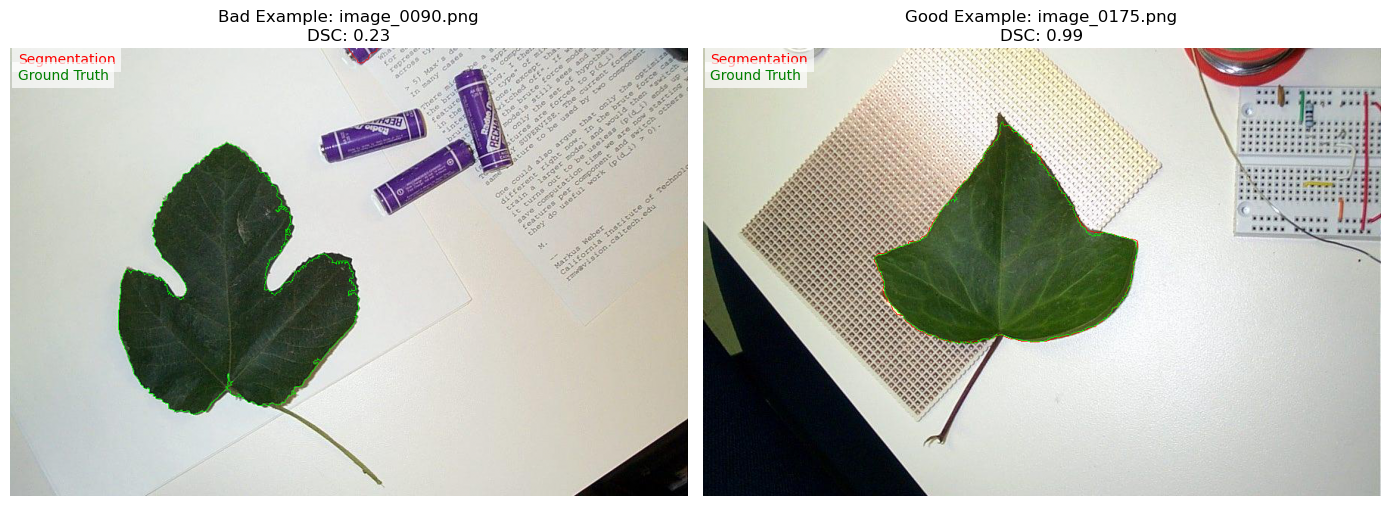

In [49]:
import matplotlib.pyplot as plt
from skimage import io, segmentation, morphology as morph

%matplotlib inline

images_path = os.path.join('/u1/cmpt487-819/data/asn3/', 'images')
gt_path = os.path.join('/u1/cmpt487-819/data/asn3/', 'groundtruth')

good_img = "image_0175.png"
bad_img  = "image_0090.png"

I_good = io.imread(os.path.join(images_path, good_img))
GT_good = io.imread(os.path.join(gt_path, good_img)) > 0
seg_good = segleaf(I_good)

DSC_good = DSC(seg_good, GT_good)

I_bad = io.imread(os.path.join(images_path, bad_img))
GT_bad = io.imread(os.path.join(gt_path, bad_img)) > 0
seg_bad = segleaf(I_bad)

DSC_bad = DSC(seg_bad, GT_bad)


overlay_good = segmentation.mark_boundaries(I_good, seg_good, color=(1,0,0))
overlay_good = segmentation.mark_boundaries(overlay_good, GT_good, color=(0,1,0))
overlay_bad  = segmentation.mark_boundaries(I_bad, seg_bad, color=(1,0,0))
overlay_bad  = segmentation.mark_boundaries(overlay_bad, GT_bad, color=(0,1,0))


plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(overlay_bad)
plt.title(f"Bad Example: {bad_img}\nDSC: {DSC_bad:.2f}")
plt.axis("off")
# legend for colors
plt.text(10, 20, "Segmentation", color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
plt.text(10, 40, "Ground Truth", color='green', fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.subplot(1,2,2)
plt.imshow(overlay_good)
plt.title(f"Good Example: {good_img}\nDSC: {DSC_good:.2f}")
plt.axis("off")
plt.text(10, 20, "Segmentation", color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
plt.text(10, 40, "Ground Truth", color='green', fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.tight_layout()
plt.show()

# Step 5: A time for reflection.

### Answer the following questions right here in this block.

1. In a few sentences, briefly explain what your segmentation algorithm from Step 1 does and how it works.  

	_Your answer:_  My algorithm segments the leaf from the background using a greeness index of 2*G - R - B, which emphasizes the green intensity from each image pixel. I then implement thresholding using Otsu's method to create a binary mask that outlines the leaf pixels. Then after I define the edges of the leafs, I use the Hough line transform function draw straight lines along each edge, and place these lines back onto the binary mask of the image to reinforce boundaries. Finally, I label all the connected regions from the mask and return the largest region which represents the leaf.

2. Consider your example "good" result.  What, if anything, about your algoirthm is preventing you from getting a better result with this image?  If you weren't able to get any results, leave this blank, or explain what was preventing you from getting a result.

	_Your answer:_  From visual inspection I can see from this result that the boundary I created was still not tight enough. Overall the boundary was still very accurate, but I think I could improve it by potentially increasing the threshold of my hough lines so that I can create lines that are more significant in regards to the edges. 

3. Consider your example "bad" result.  What is it about your algoirthm caused the poor performance?   If you weren't able to get any results, leave this blank.

	_Your answer:_  The reason my algorithm performed so poorly here is because it was not able to succesfully detect the leaf and considered the corner of the batter at the top of the image as the leaf. I believe this happened because my algorithm was not able to properly closed the boundary around the battery, and most likely expanded throughout the entire image, which is why the battery was segmentated instead of the leaf. 
